## 3.1 Treinamento do modelo

Objetivo: Treinar e selecionar o melhor modelo com base na métrica Recall.

### Importação das bibliotecas

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Carregando os dados de treino e teste (já processados)

Para evitar vazamento de dados (data leakage), o conjunto de dados foi previamente dividido em dois subconjuntos distintos: um conjunto de treinamento, utilizado exclusivamente para o ajuste do modelo, e um conjunto de teste, reservado apenas para a avaliação final do desempenho. Dessa forma, garantimos uma estimativa mais realista da capacidade de generalização do modelo.

In [26]:
# Carregando os dados já divididos e processados
X_train = pd.read_csv('../data/processed/X_train.csv', sep=';')
X_test = pd.read_csv('../data/processed/X_test.csv', sep=';')
y_train = pd.read_csv('../data/processed/y_train.csv', sep=';').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv', sep=';').squeeze()

print(f"Treino: {X_train.shape[0]} amostras × {X_train.shape[1]} features")
print(f"Teste: {X_test.shape[0]} amostras × {X_test.shape[1]} features")



Treino: 662 amostras × 13 features
Teste: 285 amostras × 13 features


### Definição do modelo

Para o treinamento dos modelos, utilizamos o **Grid Search com validação cruzada**, que avalia diferentes combinações de hiperparâmetros para cada algoritmo e seleciona aquela que apresenta o melhor desempenho de acordo com a métrica definida.

A métrica escolhida para otimização foi o **Recall**, pois ela está diretamente relacionada à minimização de **Falsos Negativos**. No contexto deste problema, um falso negativo representa um risco significativo, já que o modelo indicaria que um paciente não possui doença cardíaca quando, na realidade, ele apresenta a condição. Isso pode levar à não realização de exames necessários e ao agravamento do quadro clínico.

Por outro lado, os **Falsos Positivos** possuem um impacto menos crítico, pois resultam apenas na recomendação de exames adicionais. Embora isso possa gerar inconveniência ao paciente, não representa um risco direto à sua saúde. Dessa forma, priorizar o Recall é uma escolha adequada para maximizar a segurança clínica do modelo.

O processo de busca de hiperparâmetros foi realizado **exclusivamente com o conjunto de treinamento**, utilizando validação cruzada de 5 folds, garantindo que o conjunto de teste permanecesse isolado para a avaliação final do desempenho.

In [27]:
# Definindo os modelos e seus respectivos hiperparâmetros para Grid Search
param_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'l1_ratio': [0, 0.5, 1],  # 0=L2, 1=L1, 0.5=ElasticNet
            'solver': ['saga'],  # Saga suporta l1_ratio
            'max_iter': [500, 1000, 2000],
            'class_weight': [None, 'balanced']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.8, 1.0]
        }
    }
}

print(f"Modelos configurados: {list(param_grid.keys())}")

Modelos configurados: ['Logistic Regression', 'Random Forest', 'SVC', 'XGBoost']


In [28]:
# Executando o Grid Search para cada modelo
results = {}

for model_name, config in param_grid.items():
    print(f'\nTreinando {model_name}...')

    scorings = {
        'acuracia': 'accuracy',
        'recall': 'recall',
        'f1_score': 'f1',
        'precision': 'precision'
    }

    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring=scorings,
        refit='recall',
        n_jobs=-1,
        verbose=1
    )

    # Treinar APENAS com dados de treino
    grid.fit(X_train, y_train)

    results[model_name] = grid

    print(f'Best Recall (CV): {grid.best_score_:.4f}')


Treinando Logistic Regression...
Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\Guilherme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Guilherme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Recall (CV): 0.9646

Treinando Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Recall (CV): 0.9782

Treinando SVC...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Recall (CV): 0.9619

Treinando XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Recall (CV): 0.9864


In [29]:
# Exibindo os melhores parâmetros e scores médios para cada modelo
for model_name, grid in results.items():
    print(f'\n===== {model_name} =====')

    idx = grid.best_index_

    print('Melhores parâmetros:')
    for k, v in grid.best_params_.items():
        print(f'  {k}: {v}')

    print('\nScores médios (CV):')
    print(f"  Accuracy : {grid.cv_results_['mean_test_acuracia'][idx]:.4f}")
    print(f"  Recall   : {grid.cv_results_['mean_test_recall'][idx]:.4f}")
    print(f"  Precision: {grid.cv_results_['mean_test_precision'][idx]:.4f}")
    print(f"  F1-score : {grid.cv_results_['mean_test_f1_score'][idx]:.4f}")



===== Logistic Regression =====
Melhores parâmetros:
  C: 10
  class_weight: None
  l1_ratio: 0
  max_iter: 500
  solver: saga

Scores médios (CV):
  Accuracy : 0.9608
  Recall   : 0.9646
  Precision: 0.9648
  F1-score : 0.9646

===== Random Forest =====
Melhores parâmetros:
  bootstrap: False
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 200

Scores médios (CV):
  Accuracy : 0.9713
  Recall   : 0.9782
  Precision: 0.9706
  F1-score : 0.9742

===== SVC =====
Melhores parâmetros:
  C: 10
  kernel: rbf

Scores médios (CV):
  Accuracy : 0.9532
  Recall   : 0.9619
  Precision: 0.9549
  F1-score : 0.9580

===== XGBoost =====
Melhores parâmetros:
  colsample_bytree: 0.7
  learning_rate: 0.01
  max_depth: 5
  n_estimators: 50
  subsample: 1.0

Scores médios (CV):
  Accuracy : 0.9502
  Recall   : 0.9864
  Precision: 0.9289
  F1-score : 0.9565


### Resultados no conjunto de teste

No conjunto de teste, o modelo apresentou desempenho consistente em relação aos resultados obtidos durante a validação cruzada no conjunto de treinamento. Observou-se um **Recall de 94,97%**, indicando que o modelo é eficaz em minimizar falsos negativos, característica essencial para sua aplicação como auxiliar clínico.

Além disso, o modelo alcançou uma **Precision de 96,79%**, demonstrando que, apesar de priorizar a redução de erros graves, ele não gera um número excessivo de falsos positivos. Dessa forma, o modelo mantém um bom equilíbrio entre segurança clínica e conveniência para o paciente, evitando exames desnecessários sem comprometer a identificação de casos críticos.

Melhor modelo: XGBoost
Melhor score (Recall CV): 0.9864

AVALIAÇÃO NO CONJUNTO DE TESTE
Accuracy : 0.9544
Recall   : 0.9497
Precision: 0.9679
F1-score : 0.9587

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       126
           1       0.97      0.95      0.96       159

    accuracy                           0.95       285
   macro avg       0.95      0.96      0.95       285
weighted avg       0.95      0.95      0.95       285


Confusion Matrix:
[[121   5]
 [  8 151]]


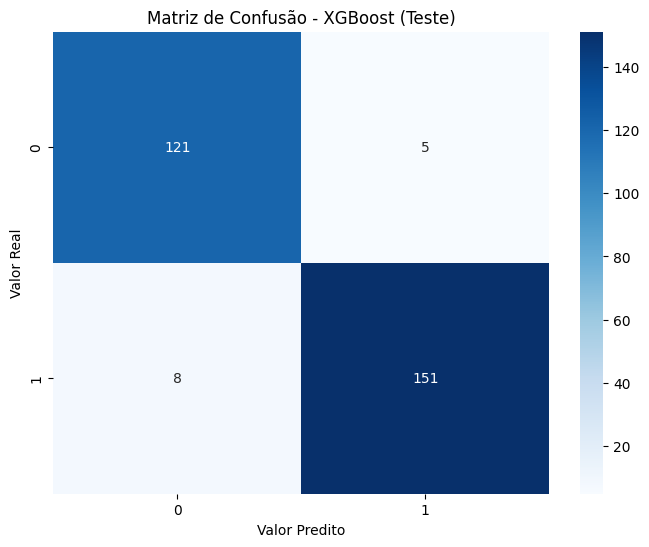


Modelo salvo em: ..\models\best_model.pkl


In [31]:
# Selecionar o melhor modelo baseado no recall
best_model_name = max(results, key=lambda x: results[x].best_score_)
best_model = results[best_model_name].best_estimator_

print(f"Melhor modelo: {best_model_name}")
print(f"Melhor score (Recall CV): {results[best_model_name].best_score_:.4f}")

# Avaliar no conjunto de TESTE (dados nunca vistos)
y_pred = best_model.predict(X_test)

print("\n" + "="*60)
print("AVALIAÇÃO NO CONJUNTO DE TESTE")
print("="*60)
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão - {best_model_name} (Teste)')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()

# Salvar o melhor modelo
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)
model_path = models_dir / 'best_model.pkl'
joblib.dump(best_model, model_path)
print(f"\nModelo salvo em: {model_path}")

Esses resultados confirmam que o modelo apresenta boa capacidade de generalização e é adequado para uso como ferramenta de apoio à decisão clínica.